# Noodlification and unification on an example

In [1]:
from noodler import *
from spot.jupyter import display_inline
from IPython.display import SVG

[Warning] The python module awalipy relies on compilation executed "on-the-fly" depending on the context (type of weights, of labels, etc.). As a result, the very first call to a given function in a given context may take up to 10 seconds. 


## System description
The string equation problem with variables $\mathsf{Var}$ is given by two components:
 1. equation $e$ of the form $e_l = e_r$ where $e_l, e_r \in \mathsf{Var}^+$. In the code, we use `e_l` and `e_r`.
 2. dictionary `constraints`${}\colon \mathsf{Var} \to \mathsf{RE(\mathsf{Var})}$. The regular expressions must be given as strings parsable by Awali, see [this guide](http://files.vaucanson-project.org/1.0/gs/RationalExpression.html) for more details.

In [2]:
def equation_str(e_l, e_r):
    return f"{e_l} = {e_r}"

In the running example, we use variables `x`,`y`, and `z` with alphabet `a,b,c`. In the following, we create an equation $xyz = xyxy$ with regular constraints
* $L_x = L_z = \Sigma^+$ and 
* $L_y = \Sigma \Sigma^+.$

In [3]:
e_l = "xyz"
e_r = "xyxy"

alph = "abc"
Sigma_exp = f"({'+'.join(alph)})"
Sigma_plus = f"{Sigma_exp}{Sigma_exp}*"
constraints = {
    "x" : Sigma_plus,
    "y" : f"{Sigma_exp}{Sigma_plus}",
    "z" : Sigma_plus
}

In [4]:
print(equation_str(e_l, e_r))
for var, cons in constraints.items():
    print(f"constraint for {var}: {cons}")

xyz = xyxy
constraint for x: (a+b+c)(a+b+c)*
constraint for y: (a+b+c)(a+b+c)(a+b+c)*
constraint for z: (a+b+c)(a+b+c)*


## Representation by segment automata

Our algorithm works with _segment automata_. Automata, which can be split to segments by removing ε-transitions. The idea is, roughly, that a segment automaton represents a concatenation of automata for a side of the input equation. To specify the system from above, we need 2 segment automata (one for each side), and the equation (for further reference).

### Automata for variables
Let's see first the automata for each varible.

In [5]:
automata = {}
for var, re_str in constraints.items():
    re = awalipy.RatExp(re_str, alphabet=alph)
    automata[var] = re.exp_to_aut()
for var, aut in automata.items():
    display_inline(var, SVG(aut.svg()))

### Segment automata
Now we create segment automata for each side of the equations, by chaining the automata from above by ε-transitions. Each segment automaton represents the language of the corresponding side of the equation. We store the segment automata in `chain_l` and `chain_r`. Further, we remember the sequence of automata we chained in `automata_l` and `automata_r`.

In [6]:
automata_l = automata_for_vars(e_l, constraints, alph)
automata_r = automata_for_vars(e_r, constraints, alph)
chain_l = chain_automata(automata_l)
chain_r = chain_automata(automata_r)

Segment automaton for the left side of equation:


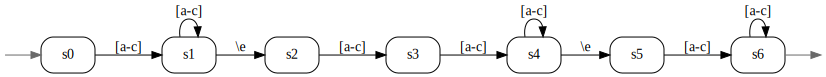

Segment automaton for the right side of equation:


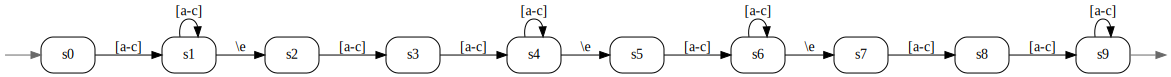

In [7]:
print("Segment automaton for the left side of equation:")
chain_l.display()
print("Segment automaton for the right side of equation:")
chain_r.display()

## The algo based on segment automata

![algo](img/string_algo.png)

## Make the pastry and make and noodles
Lines 2 and 3 of the algorithm basically make a product (pastry) of the segment automata for the two sides, and create **noodles** from this product. 

### Pastry a.k.a product
The product is of a special kind: left-ε-transition-preserving. Basically, we create a minimal automaton for the language of the right side of the equation and make a product with the segment automaton for the left side (`chain_l`). The result is, again, a segment automaton (with the same number of segments as `chain_l`).

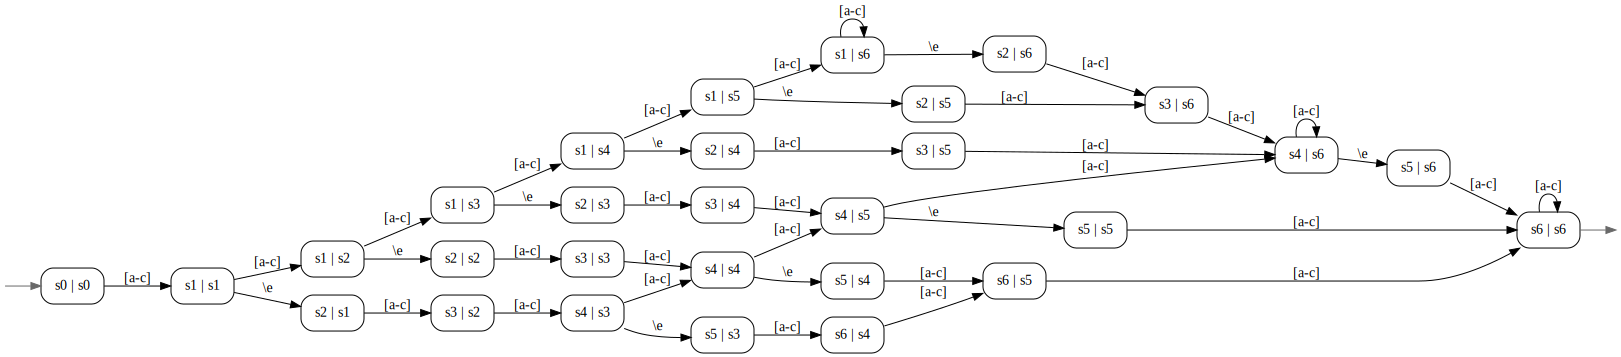

In [8]:
product = one_sided_product(chain_l, chain_r, {"history" : True})
product.display()

### Noodlify!
A noodle is a part of the pastry where we keep only one ε-transition between each two consecutive segments. The task of noodlify is to create all meaningfull noodles. For a segment automaton with $k+1$ segments and at most $t$ ε-transitions between each two consecutive segments, we have at most $k \times t$ noodles.

Let $T_1, T_2, \ldots T_k$ be the sets of ε-transitions between segments: 
 * $\mathrm{seg}_1 \xrightarrow{T_1} \mathrm{seg}_2$
 * $\mathrm{seg}_2 \xrightarrow{T_2} \mathrm{seg}_3$
 * ...
 * $\mathrm{seg}_k \xrightarrow{T_k} \mathrm{seg}_k$
 
Then the set of noodles is basically defined by the cartesian product $T_1 \times T_2 \times \ldots T_k$. Of course, we return only those noodles whose language is non-empty.

We have 12 noodles


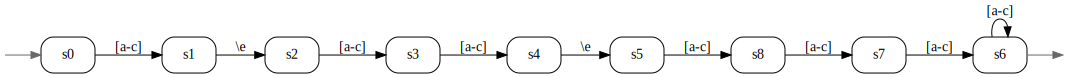

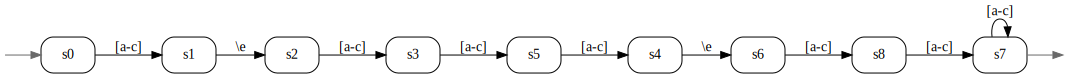

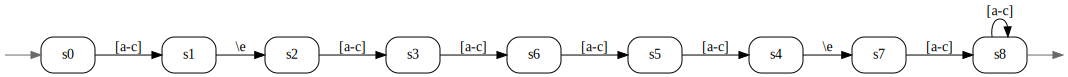

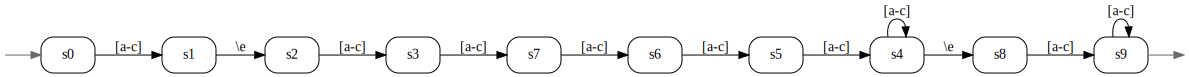

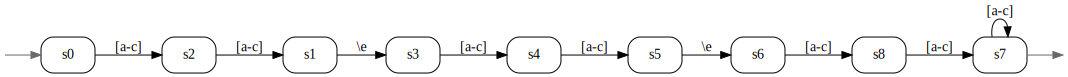

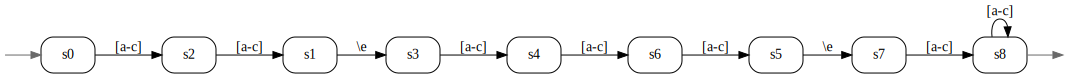

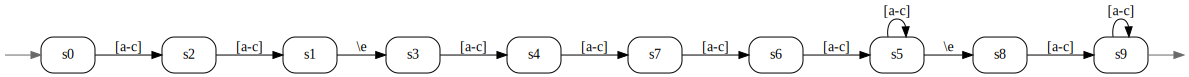

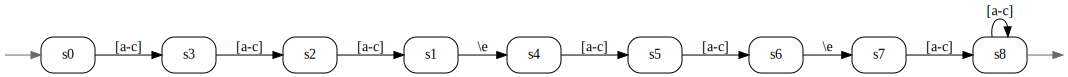

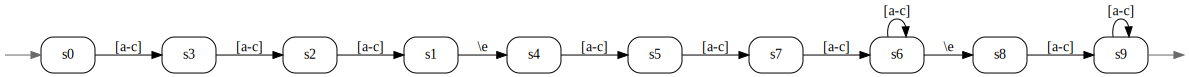

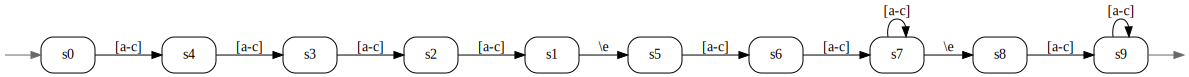

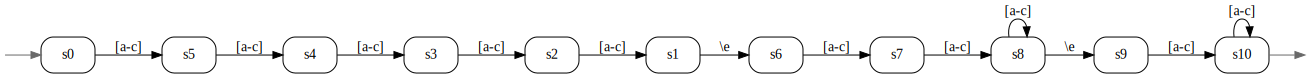

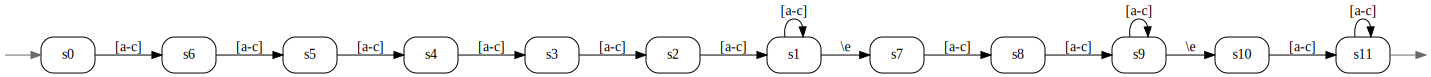

In [9]:
noodles = noodlify(product, include_empty=False)
print(f"We have {len(noodles)} noodles")
for noodle in noodles:
    noodle.display()

## Process the noodle
Now for each noodle and the original right-side segment automaton we run **unification** (line 6). Each noodle itself is a segment automaton again. Unification ensures in these two automata that the segments that correspond to the same variable of the equation represent the same language. So we split the segment automaton of the noodle into segments and unify them with the segments of the right-hand side.

We demonstrate this on the first and the last noodle.

In [15]:
def display_unification(noodle, right_aut, e_l, e_r):
    print("The noodle before splitting.")
    noodle.display()
    aut_l = split_segment_aut(noodle)
    aut_r = split_segment_aut(right_aut)
    unified_l, unified_r = unify(e_l, e_r, aut_l, aut_r, make_copies=False)
    print(f"Left automata ({e_l}) after unification")
    for var_i, a in enumerate(unified_l):
        display_inline(f"{e_l[var_i]}:", SVG(a.svg()))
    print("==========================================")
    print(f"Right automata ({e_r}) after unification")
    for var_i, a in enumerate(unified_r):
        display_inline(f"{e_r[var_i]}:", SVG(a.svg()))
    print("==========================================")

The unification of the first noodle.

The noodle before splitting.


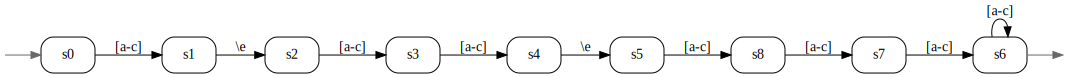

Left automata (xyz) after unification


Right automata (xyxy) after unification


In [16]:
display_unification(noodles[0], chain_r, e_l, e_r)

### The unification of the last noodle.

The noodle before splitting.


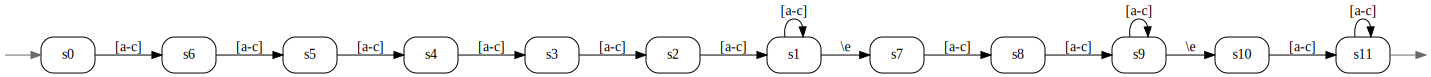

Left automata (xyz) after unification


Right automata (xyxy) after unification


In [17]:
display_unification(noodles[-1], chain_r, e_l, e_r)